# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Possible Features:

  * Average Batsman Rating (top 5) 
  * Average Bowler Rating (top 4)
  * Player of the match frequency 
  * Previous Encounter - Win by runs, Win by Wickets 
  * Recent form (Last 5 Games)
  * Venue - Home, Away, Neutral

In [47]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
from __future__ import division

## Data Mining
  

In [48]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [49]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [50]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
print "Teams selected:\n"
for team in matches_teams.team1.unique():
    print team

Teams selected:

Kolkata Knight Riders
Chennai Super Kings
Rajasthan Royals
Mumbai Indians
Kings XI Punjab
Royal Challengers Bangalore
Delhi Daredevils


In [51]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]

In [52]:
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

# Building Features

In [53]:
# Team Strike rates for first 5 batsmen in the team (Higher the better)

def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    if total_balls != 0: 
        return (total_runs/total_balls) * 100
    else:
        return None


def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        bsr = getBatsmanStrikeRate(batsman, match_id)
        if bsr != None:
            strike_rates.append(bsr)
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [54]:
# Testing Functionality
getAverageStrikeRates(517)


(126.98024523159935, 128.55579510411653)

In [55]:
# Bowler Rating : Wickets/Run (Higher the Better)
# Team 1: Batting First; Team 2: Fielding First

def getInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()[0:4]

def getInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()[0:4]

def getBowlerWPR(bowler, match_id):
    balls = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['bowler'] == bowler)]
    total_runs = balls['total_runs'].sum()
    total_wickets = balls.loc[balls['dismissal_kind'].isin(['caught', 'bowled', 'lbw', \
    'caught and bowled', 'stumped'])].shape[0]
    if total_runs != 0:
        return (total_wickets/total_runs) * 100
    else:
        return total_wickets

def getTeamWPR(bowlers, match_id):
    totalWPRs = []
    for bowler in bowlers:
        totalWPRs.append(getBowlerWPR(bowler, match_id))
    return np.mean(totalWPRs)

def getAverageWPR(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBowlers = getInningsOneBowlers(match_deliveries)
    innTwoBowlers = getInningsTwoBowlers(match_deliveries)
    teamOneWPR = getTeamWPR(innTwoBowlers, match_id)
    teamTwoWPR = getTeamWPR(innOneBowlers, match_id)
    return teamOneWPR, teamTwoWPR

In [56]:
#Testing Functionality 
getAverageWPR(517)

(2.7641806594085776, 4.4721111768026631)

In [57]:
# Man of the Match Awards for players of both Teams 

def getInningsOneAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()

def getInningsTwoAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()

def getInningsOneAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()

def getInningsTwoAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()

def getTeam(batsmen,bowlers):
    p = []
    p = np.append(p, batsmen)
    for i in bowlers:
        if i not in batsmen:
            p = np.append(p, i)
    return p

def getPlayerMVPAwards(player, match_id):
    return matches.loc[(matches["player_of_match"] == player) & (matches['id'] < match_id)].shape[0]

def getTeamMVPAwards(team, match_id):
    mvpAwards = 0
    for player in team:
        mvpAwards = mvpAwards + getPlayerMVPAwards(player,match_id)
    
    return mvpAwards

def bothTeamMVPAwards(match_id):
    matchDeliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneAllBatsmen(matchDeliveries)
    innTwoBatsmen = getInningsTwoAllBatsmen(matchDeliveries)
    innOneBowlers = getInningsTwoAllBowlers(matchDeliveries)
    innTwoBowlers = getInningsOneAllBowlers(matchDeliveries)
    team1 = getTeam(innOneBatsmen, innTwoBowlers)
    
    team2 = getTeam(innTwoBatsmen, innOneBowlers)
    team1Awards = getTeamMVPAwards(team1,match_id)
    team2Awards = getTeamMVPAwards(team2,match_id)
    return team1Awards, team2Awards

        

 



In [58]:
#Testing Functionality
bothTeamMVPAwards(517)

(28, 52)

In [59]:
#Function to generate squad rating 

def generateSquadRating(match_id):
    gameday_teams = deliveries.loc[(deliveries['match_id'] == match_id)].batting_team.unique()
    teamOne = gameday_teams[0]
    teamTwo = gameday_teams[1]
    teamOneSR, teamTwoSR = getAverageStrikeRates(match_id)
    teamOneWPR, teamTwoWPR = getAverageWPR(match_id)
    teamOneMVPs, teamTwoMVPs = bothTeamMVPAwards(match_id)
    print "Comparing squads for {} vs {}".format(teamOne,teamTwo)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamOne,teamOneSR)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamTwo,teamTwoSR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamOne,teamOneWPR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamTwo,teamTwoWPR)
    print "\nNumber of MVP Awards in {} : {}".format(teamOne,teamOneMVPs)
    print "\nNumber of MVP Awards in {} : {}".format(teamTwo,teamTwoMVPs)

In [60]:
#Testing Functionality
generateSquadRating(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating (W/R) for Mumbai Indians : 2.76418065941

Bowler Rating (W/R) for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


In [61]:
## 2nd Feature : Previous Encounter
# Won by runs and won by wickets (Higher the better)

def getTeam1(match_id):
    return matches.loc[matches["id"] == match_id].team1.unique()

def getTeam2(match_id):
    return matches.loc[matches["id"] == match_id].team2.unique()

def getPreviousEncDF(match_id):
    team1 = getTeam1(match_id)
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (((matches["team1"].isin(team1)) & (matches["team2"].isin(team2))) | ((matches["team1"].isin(team2)) & (matches["team2"].isin(team1))))]
def getTeamWBR(match_id, team):
    WBR = 0
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBR = winnerDF['win_by_runs'].sum()    
    return WBR


def getTeamWBW(match_id, team):
    WBW = 0 
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBW = winnerDF['win_by_wickets'].sum()
    return WBW 
    
def getTeamWinPerc(match_id):
    dF = getPreviousEncDF(match_id)
    timesPlayed = dF.shape[0]
    team1 = getTeam1(match_id)[0].strip("[]")
    timesWon = dF.loc[dF["winner"] == team1].shape[0]
    if timesPlayed != 0:
        winPerc = (timesWon/timesPlayed) * 100
    else:
        winPerc = 0
    return winPerc

def getBothTeamStats(match_id):
    DF = getPreviousEncDF(match_id)
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    timesPlayed = DF.shape[0]
    timesWon = DF.loc[DF["winner"] == team1].shape[0]
    WBRTeam1 = getTeamWBR(match_id, team1)
    WBRTeam2 = getTeamWBR(match_id, team2)
    WBWTeam1 = getTeamWBW(match_id, team1)
    WBWTeam2 = getTeamWBW(match_id, team2)

    print "Out of {} times in the past {} have won {} times({}%) from {}".format(timesPlayed, team1, timesWon, getTeamWinPerc(match_id), team2)
    print "{} won by {} total runs and {} total wickets.".format(team1, WBRTeam1, WBWTeam1)
    print "{} won by {} total runs and {} total wickets.".format(team2, WBRTeam2, WBWTeam2)




In [62]:
#Testing functionality 
getBothTeamStats(517)


Out of 21 times in the past Mumbai Indians have won 11 times(52.380952381%) from Chennai Super Kings
Mumbai Indians won by 144 total runs and 30 total wickets.
Chennai Super Kings won by 138 total runs and 31 total wickets.


In [63]:
#3rd Feature: Recent Form (Win Percentage of 3 previous matches of a team in the same season)
#Higher the better

def getMatchYear(match_id):
    return matches.loc[matches["id"] == match_id].season.unique()

def getTeam1DF(match_id, year):
    team1 = getTeam1(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team1)) | (matches["team2"].isin(team1)))].tail(3)

def getTeam2DF(match_id, year):
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team2)) | (matches["team2"].isin(team2)))].tail(3)

def getTeamWinPercentage(match_id):
    win = 0
    total = 0
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    team1DF = getTeam1DF(match_id, year)
    team2DF = getTeam2DF(match_id, year)
    team1TotalMatches = team1DF.shape[0]
    team1WinMatches = team1DF.loc[team1DF["winner"] == team1].shape[0]
    team2TotalMatches = team2DF.shape[0]
    team2WinMatches = team2DF.loc[team2DF["winner"] == team2].shape[0]
    if (team1TotalMatches != 0) and (team2TotalMatches !=0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    elif (team1TotalMatches != 0) and (team2TotalMatches ==0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = 0
    elif (team1TotalMatches == 0) and (team2TotalMatches !=0):
        winPercTeam1 = 0
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    else:
        winPercTeam1 = 0
        winPercTeam2 = 0
        
    return winPercTeam1, winPercTeam2
    
    
def displayTeamWin(match_id):
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    P,Q = getTeamWinPercentage(match_id)
    print "In the season of {}, {} has a win percentage of {}% and {} has a win percentage of {}% ".format(year, team1, P, team2, Q)

In [64]:
#Function to implement all features
def getAllFeatures(match_id):
    generateSquadRating(match_id)
    print ("\n")
    getBothTeamStats(match_id)
    print("\n")
    displayTeamWin(match_id)


In [65]:
#Testing Functionality
getAllFeatures(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating (W/R) for Mumbai Indians : 2.76418065941

Bowler Rating (W/R) for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


Out of 21 times in the past Mumbai Indians have won 11 times(52.380952381%) from Chennai Super Kings
Mumbai Indians won by 144 total runs and 30 total wickets.
Chennai Super Kings won by 138 total runs and 31 total wickets.


In the season of 2015, Mumbai Indians has a win percentage of 66.6666666667% and Chennai Super Kings has a win percentage of 66.6666666667% 


# Adding Columns


In [66]:
#Create Column for Team 1 Winning Status (1 = Won, 0 = Lost)

matches['team1Winning'] = np.where(matches['team1'] == matches['winner'], 1, 0)

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
#New Column for Difference of Average Strike rates (First Team SR - Second Team SR) [Negative value means Second team is better]

firstTeamSR = []
secondTeamSR = []
for i in matches['id'].unique():
    P, Q = getAverageStrikeRates(i)
    firstTeamSR.append(P), secondTeamSR.append(Q)
firstSRSeries = pd.Series(firstTeamSR)
secondSRSeries = pd.Series(secondTeamSR)
matches["Avg_SR_Difference"] = firstSRSeries.values - secondSRSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [68]:
#New Column for Difference of Wickets Per Run (First Team WPR - Second Team WPR) [Negative value means Second team is better]

firstTeamWPR = []
secondTeamWPR = []
for i in matches['id'].unique():
    R, S = getAverageWPR(i)
    firstTeamWPR.append(R), secondTeamWPR.append(S)
firstWPRSeries = pd.Series(firstTeamWPR)
secondWPRSeries = pd.Series(secondTeamWPR)
matches["Avg_WPR_Difference"] = firstWPRSeries.values - secondWPRSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [69]:
#New column for difference of MVP Awards (Negative value means Second team is better)

firstTeamMVP = []
secondTeamMVP = []
for i in matches['id'].unique():
    T, U = bothTeamMVPAwards(i)
    firstTeamMVP.append(T), secondTeamMVP.append(U)
firstMVPSeries = pd.Series(firstTeamMVP)
secondMVPSeries = pd.Series(secondTeamMVP)
matches["Total_MVP_Difference"] = firstMVPSeries.values - secondMVPSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [70]:
#New column for win percentage of Team1 in previous encounter 

firstTeamWP = []
for i in matches['id'].unique():
    WP = getTeamWinPerc(i)
    firstTeamWP.append(WP)
firstWPSeries = pd.Series(firstTeamWP)
matches["Prev_Enc_Team1_WinPerc"] = firstWPSeries.values




/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
#New column for Recent form(Win Percentage in the current season) of 1st Team compared to 2nd Team(Negative means 2nd team has higher win percentage)

firstTeamRF = []
secondTeamRF = []
for i in matches['id'].unique():
    K, L = getTeamWinPercentage(i)
    firstTeamRF.append(K), secondTeamRF.append(L)
firstRFSeries = pd.Series(firstTeamRF)
secondRFSeries = pd.Series(secondTeamRF)
matches["Total_RF_Difference"] = firstRFSeries.values - secondRFSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [72]:
#Testing 
matches.tail(20)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,team1Winning,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc,Total_RF_Difference
489,490,2015,Mumbai,2015-05-01,Mumbai Indians,Rajasthan Royals,Rajasthan Royals,field,normal,0,Mumbai Indians,8,0,AT Rayudu,Wankhede Stadium,HDPK Dharmasena,CK Nandan,NaN,1,-13.536521,0.097342,5,60.000000,-33.333333
490,491,2015,Bangalore,2015-05-02,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Royal Challengers Bangalore,0,7,Mandeep Singh,M Chinnaswamy Stadium,JD Cloete,PG Pathak,NaN,0,4.510188,-0.570758,7,57.142857,0.000000
492,493,2015,Chandigarh,2015-05-03,Mumbai Indians,Kings XI Punjab,Mumbai Indians,bat,normal,0,Mumbai Indians,23,0,LMP Simmons,"Punjab Cricket Association Stadium, Mohali",RK Illingworth,VA Kulkarni,NaN,1,-13.615487,-0.737024,-1,46.666667,66.666667
493,494,2015,Mumbai,2015-05-03,Rajasthan Royals,Delhi Daredevils,Delhi Daredevils,field,normal,0,Rajasthan Royals,14,0,AM Rahane,Brabourne Stadium,HDPK Dharmasena,CB Gaffaney,NaN,1,10.775508,0.786552,7,60.000000,0.000000
494,495,2015,Chennai,2015-05-04,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,bat,normal,0,Chennai Super Kings,24,0,SK Raina,"MA Chidambaram Stadium, Chepauk",C Shamshuddin,K Srinath,NaN,1,4.569589,-0.231439,25,58.823529,0.000000
496,497,2015,Mumbai,2015-05-05,Delhi Daredevils,Mumbai Indians,Delhi Daredevils,bat,normal,0,Mumbai Indians,0,5,Harbhajan Singh,Wankhede Stadium,HDPK Dharmasena,CB Gaffaney,NaN,0,-18.726971,-0.755737,-14,53.333333,-33.333333
497,498,2015,Bangalore,2015-05-06,Royal Challengers Bangalore,Kings XI Punjab,Kings XI Punjab,field,normal,0,Royal Challengers Bangalore,138,0,CH Gayle,M Chinnaswamy Stadium,RK Illingworth,VA Kulkarni,NaN,1,-5.574733,0.886535,5,35.714286,66.666667
499,500,2015,Chennai,2015-05-08,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,HH Pandya,"MA Chidambaram Stadium, Chepauk",CB Gaffaney,CK Nandan,NaN,0,5.014283,1.972348,17,52.631579,0.000000
500,501,2015,Kolkata,2015-05-09,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,bat,normal,0,Kolkata Knight Riders,0,1,AD Russell,Eden Gardens,AK Chaudhary,HDPK Dharmasena,NaN,0,6.415078,0.254813,-18,40.000000,-33.333333
502,503,2015,Mumbai,2015-05-10,Royal Challengers Bangalore,Mumbai Indians,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,39,0,AB de Villiers,Wankhede Stadium,JD Cloete,C Shamshuddin,NaN,1,-1.343308,2.062729,-3,43.750000,-33.333333


# Visualisation


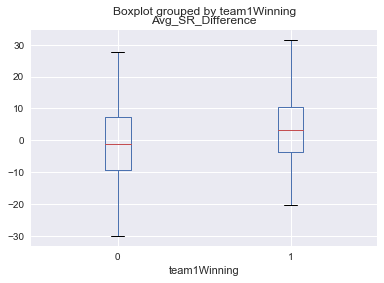

In [73]:
#Graph for Strike Rate  
matches.boxplot(column = 'Avg_SR_Difference', by='team1Winning', showfliers= False)

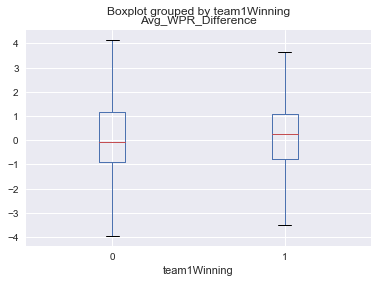

In [74]:
#Graph for WPR Difference
matches.boxplot(column = 'Avg_WPR_Difference', by='team1Winning', showfliers= False)

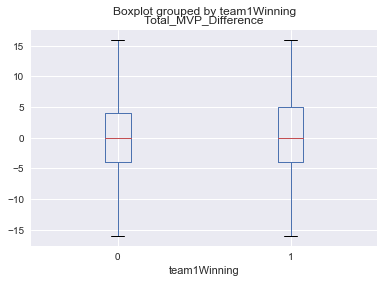

In [75]:
# Graph for MVP Difference
matches.boxplot(column = 'Total_MVP_Difference', by='team1Winning', showfliers= False)

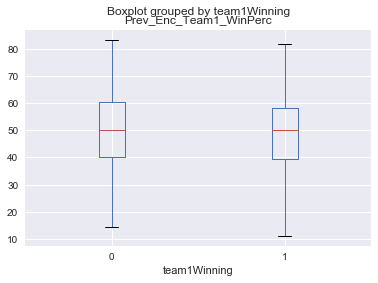

In [76]:
#Graph for Previous encounters Win Percentage of Team #1
matches.boxplot(column = 'Prev_Enc_Team1_WinPerc', by='team1Winning', showfliers= False)

In [ ]:
# Graph for Recent form(Win Percentage in the same season)
matches.boxplot(column = 'Total_RF_Difference', by='team1Winning', showfliers= False)

# Predictions for the data

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from patsy import dmatrices

In [78]:
y, X = dmatrices('team1Winning ~ 0 + Avg_SR_Difference + Avg_WPR_Difference + Total_MVP_Difference + Prev_Enc_Team1_WinPerc + \
                  Total_RF_Difference', matches, return_type="dataframe")
y_arr = np.ravel(y)

### Training and testing on Entire Data

In [79]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y_arr)
# check the accuracy on the training set
print "Accuracy is", model.score(X, y_arr)*100, "%"

Accuracy is 58.1039755352 %


### Splitting train and test using train_test_split

In [80]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, random_state = 0)

In [81]:
# Logistic Regression on train_test_split
model2 = LogisticRegression()
model2.fit(X_train, y_train)
# predict class labels for the test set
predicted = model2.predict(X_test)
# generate evaluation metrics
print "Accuracy is ", metrics.accuracy_score(y_test, predicted)*100, "%"

Accuracy is  58.5365853659 %


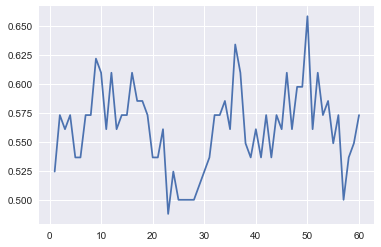

In [82]:
# KNN Classification on train_test_split
k_range = list(range(1, 61))
k_score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_score.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, k_score)

In [83]:
# Best values of k in train_test_split
knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Accuracy is ", metrics.accuracy_score(y_test, y_pred)*100, "%" 

Accuracy is  65.8536585366 %


### Splitting Training Set (2008-2013) and Test Set (2013-2015) based on Seasons



In [84]:
#Splitting
X_timetrain = X.loc[X.index < 398]
Y_timetrain = y.loc[y.index < 398]
Y_timetrain_arr = np.ravel(Y_timetrain)
X_timetest = X.loc[X.index >= 398]
Y_timetest = y.loc[y.index >= 398]
Y_timetest_arr = np.ravel(Y_timetest)

In [85]:
# Logistic Regression on time-based split sets
model3 = LogisticRegression()
model3.fit(X_timetrain, Y_timetrain_arr)
timepredicted = model3.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, timepredicted)*100, "%"

Accuracy is  51.724137931 %


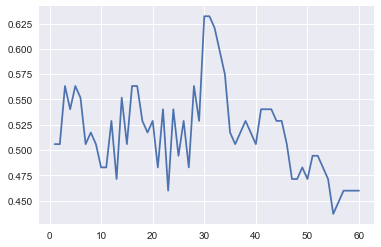

In [86]:
# KNN Classification on time-based split sets
k_range = list(range(1, 61))
k_score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_timetrain, Y_timetrain_arr)
    y_pred = knn.predict(X_timetest)
    k_score.append(metrics.accuracy_score(Y_timetest_arr, y_pred))
plt.plot(k_range, k_score) 

In [87]:
# Best values of k in time-based split data
knn1 = KNeighborsClassifier(n_neighbors = 31)
knn1.fit(X_timetrain, Y_timetrain_arr)
y_pred = knn1.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, y_pred)*100, "%"

Accuracy is  63.2183908046 %


### Support Vector Machines

In [88]:
clf = svm.SVC(gamma=0.001, C=10)
clf.fit(X_timetrain, Y_timetrain_arr)
clf_pred = clf.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, clf_pred)*100, "%"

Accuracy is  48.275862069 %


### Random Forests

In [89]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = 1)
rfc.fit(X_timetrain, Y_timetrain_arr)
rfc_pred = rfc.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, rfc_pred)*100, "%"

Accuracy is  47.1264367816 %


In [90]:
fi = zip(X.columns, rfc.feature_importances_)
print "Feature Importance according to Random Forests Model\n"
for i in fi:
    print i[0], ":", i[1]

Feature Importance according to Random Forests Model

Avg_SR_Difference : 0.303135787959
Avg_WPR_Difference : 0.280738074933
Total_MVP_Difference : 0.172786216394
Prev_Enc_Team1_WinPerc : 0.13956540915
Total_RF_Difference : 0.103774511565


### Naive Bayes Classifier

In [91]:
gclf = GaussianNB()
gclf.fit(X_timetrain, Y_timetrain_arr)
gclf_pred = gclf.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, gclf_pred) *100, "%"

Accuracy is  50.5747126437 %
